# Tensor basics

**Course**: Computer Vision (911.908)    
**Author**: Roland Kwitt (Dept. of Computer Science, Univ. of Salzburg)       
Winter term 2019/20

---

This introduction only provides the very basics of working with tensors (in PyTorch). For a more comprehensive overview (and introduction), see the PyTorch documentation.

*Acknowledgements*: Part of this lecture is taken from Francois Fleuret's [Tensor basics and linear regression](https://fleuret.org/ee559/ee559-slides-1-4-tensors-and-linear-regression.pdf) and [Higher dimension tensors](https://fleuret.org/ee559/ee559-slides-1-5-high-dimension-tensors.pdf) material at EPFL.

---

Basically, a tensor is a *generalized matrix*. A

- .. 0d tensor is a scalar
- .. 1d tensor is a vector
- .. 2d tensor is a matrix
- .. 3d tensor can be interpreted as a vector of identically-sized matrices
- .. 4d tensor can be interpreted as a matrix of identically-sized matrices
- etc.

We will use tensors to encode the input/output signals, intermediate outputs, and also the parameters (internal states) of our models. In **PyTorch**, we have efficient tensor operations available on CPU/GPU, automatic differentiation (will be discussed later), etc. If a tensor is stored in memory on a certain device (GPU/CPU), operations are performed by that device.

## Tensor types

We have the following data types available for tensors:

- `torch.float16`
- `torch.float32`
- `torch.float64`
- `torch.uint8`
- `torch.int8`
- `torch.int16`
- `torch.int32`
- `torch.int64`

For `torch.float32`, the corresponding CPU tensor is `torch.FloatTensor` and the corresponding GPU tensor is `torch.cuda.FloatTensor`.

For a full listing see [here](https://pytorch.org/docs/stable/tensors.html). 

Note that `torch.Tensor` defaults to `torch.FloatTensor`. The preferred construction of tensors happens via `torch.tensor`.

In [1]:
import numpy as np
import torch

%matplotlib inline
import matplotlib.pyplot as plt

---

## Writing device-agnostic code

In some cases, we might want to run our code on CPU, in other cases we might want to run it on the GPU. Writing device-agnostic code is simple in PyTorch. We just set the `device` variable to the correct device that we have available. 

Note that if you have multiple GPUs, we can directly specify the GPU ID via `cuda:x`, e.g., `cuda:2`.




In [2]:
use_gpu = True
if torch.cuda.is_available() and use_gpu: 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
print(device)

cpu


---

## Tensor creation & Filling

In [8]:
x = torch.empty(3, 2, 
                dtype=torch.float64, 
                device=device)

print(x)
print('Tensor type:', x.dtype)
print('Device:', x.device)

tensor([[ 4.5177e-37,  6.5936e-66],
        [ 6.5852e-66,  5.3958e-62],
        [6.7014e+170,  8.2332e-67]], dtype=torch.float64)
Tensor type: torch.float64
Device: cpu


In [9]:
# 3x2 tensor filled with zeros
y = torch.zeros(3, 2, 
                device=device) 
print(y)

# tensor of same size as x, filled with zeros
y = torch.zeros_like(x, device=device) 
print(y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)


In [10]:
# create 3x2 tensor of all ones
x = torch.ones(3, 2, 
               device=device)
print(x)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


We can also create tensors from numpy arrays. Unless we specify the tensor type directly, the `numpy` array type is inherited.

In [11]:
x = np.array(
    [
        [1,2,3],
        [4,5,6]
    ])
t = torch.tensor(x, device=device)
print(t)
print(t.dtype)

x = np.array(
    [
        [1,2,3],
        [4,5,6]
    ])
t = torch.tensor(x, 
                 dtype=torch.float32,
                 device=device)
print(t)
print(t.dtype)

tensor([[1, 2, 3],
        [4, 5, 6]])
torch.int64
tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.float32


---

## In-place operations

In [12]:
x = torch.empty(3, 1, device=device, dtype=torch.float32)
y = torch.empty(3, 1, device=device, dtype=torch.float32)

x.fill_(1) # fill tensor with ones
y.zero_()  # set all elements to zero

print(x)
print(y)

tensor([[1.],
        [1.],
        [1.]])
tensor([[0.],
        [0.],
        [0.]])


**Note**: In-place operations are prefixed with a `_`, such as `x.zero_()` or `x.fill_(1.0)` or `x.normal_()`. The latter fills the tensor with values sampled from a standard Gaussian $\mathcal{N}(0,1)$.

---

## Reduction operations

In [13]:
x = torch.zeros(3, 2, 
                device=device).normal_()

s0 = x.sum()  # sum over all tensor values
s1 = x.mean() # mean over all tensor values
s2 = x.std()  # computed the standard deviation over all tensor values
s3 = x.norm() # matrix norm of x (in that case Frobenius norm)

print(s0.item())
print(s1.item())
print(s2.item())
print(s3.item())

0.4520333409309387
0.07533889263868332
1.1766647100448608
2.637566089630127


Note that While `s0`-`s3` are scalars, they are encoded as a 0d tensor. To get a Python number, we call `.item()`.

---

## Indexing

Indexing starts at 0 (as usual in our context). Say you have a $3 \times 2$ tensor `x`. The dimensionality along the first dimension is $3$ and along the second dimension $2$. To get the value at $(i,j)$, we specify
`x[i,j]`.

In [14]:
x = torch.rand(3, 2, 
               device=device)
print(x)
print(x[2,0].item()) # print item at position 2,0

tensor([[0.2563, 0.6367],
        [0.8823, 0.5011],
        [0.7529, 0.2420]])
0.7528554201126099


In [15]:
x = torch.empty(3, 10, 12, 
               device=device).normal_()
print(x[0,8,2])

tensor(0.3310)


---
## Slicing

We can also extract certain parts of a tensor, using *slicing*, e.g., if `x = torch.rand(3,10,12)` as before, we have $3$ $10 \times 12$ matrices in this tensor, or, a vector (of length 3) of $10 \times 12$ matrices. To extract the first vector element (i.e., the first $10 \times 12$ matric), we write

In [16]:
z = x[0,:,:]
print(z)

tensor([[ 1.3244,  0.2518, -0.7805,  1.7184, -0.2383, -0.9484, -1.6454,  0.7663,
          0.6123, -0.2931,  0.8742, -0.2811],
        [ 1.1235,  1.0978, -0.3569,  0.4350,  1.3653, -0.2256,  0.3679,  0.5051,
          0.0490, -0.2737, -0.2045, -0.4338],
        [ 1.5517,  0.5507,  0.2066, -0.9545, -0.8519, -0.7394,  0.3193, -1.6054,
         -0.4178, -2.0181, -0.3077, -1.0139],
        [ 0.0215, -1.1690, -1.5544, -1.1071,  0.1002, -0.1018, -0.0291,  1.0324,
          1.0389,  0.1789, -0.2399, -1.1265],
        [-0.3855,  1.3820, -0.2190, -0.9360,  0.3843,  0.2968, -1.3169, -0.3736,
         -2.6535, -1.8070, -0.2816, -0.5183],
        [-0.4779,  0.0531, -1.6829,  1.4525, -0.0101,  1.2799, -0.1469, -1.4155,
         -0.3862, -0.4008,  0.5317, -0.7271],
        [ 0.5192,  0.9557,  0.0185, -0.8269, -2.2166,  1.0441,  1.0572,  1.9339,
         -0.3311,  1.1702, -0.3647,  1.1558],
        [ 0.4808, -0.2669,  0.8883,  0.3191,  0.5722,  0.7100,  0.6647,  0.4630,
         -0.3190,  0.7122,  1.

**Note**: If we modify a value in `z`, we also modify the value in `x`.

Slicing also allows to set all values of a slice to something:

In [17]:
x[0,:,:] = 2
print(z)

x[0,:,:].zero_()
print(z)

tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 

---

## Views

We can also easily create different *views* of a tensor. A common procedure is to view the tensor as a vector, which can easily be done via: 

In [18]:
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 1d view
v = x.view(-1)
print(v)

# view as 3x2 tensor
v = x.view(3,-1)
print(v)

# ... or more explicitely
v = x.view(3, 2)
print(v)

tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([1, 2, 3, 4, 5, 6])
tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([[1, 2],
        [3, 4],
        [5, 6]])


`v` now is a 1d view of the tensor `x`. Again, modifying $v$ modifies `x`. Also, the original size of `x` does not change.

### Expansion

*Expansion* expands singleton dimensions to a larger size (by creating a new view *without* memory consumption). In the next example we have a $2 \times 3$ tensor and want to expand this one to a $3 \times 2 \times 3$ tensor, i.e., expansion along the first singleton dimension.

In [19]:
x = torch.tensor(
    [
        [1,2,3],
        [4,5,6]
    ])

y = x.expand(3,2,3)
print(y)
print(y.size())

tensor([[[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]]])
torch.Size([3, 2, 3])


---

## Images as tensors

Images are just tensors ... it's that simple!

In [21]:
import torch, torchvision

cifar = torchvision.datasets.CIFAR10(
    './cifar10/', 
    train = False,
    download = True)

Files already downloaded and verified


In [22]:
x = torch.from_numpy(cifar.data).permute(0, 3, 1, 2).float()
x.size()

torch.Size([10000, 3, 32, 32])

So, using the `torchvision` module, we have just loaded *all* images from the CIFAR-10 testing set. CIFAR-10 are RGB images (hence 3 color channels) and we have 10,000 images available. Consequently, we get a $10000 \times 3 \times 32 \times 32$ tensor.

This is the convention for multi-channel images in PyTorch, i.e., nr. of images times channels times width times height. For visualization using `matplotlib` we need to permute the channels, though:

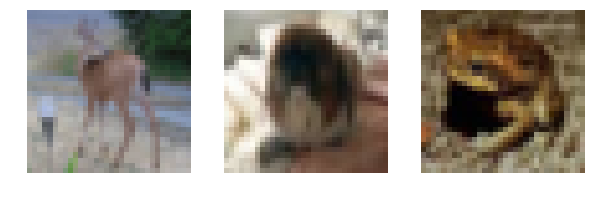

In [23]:
def show(img):
    npimg = img.numpy()
    plt.imshow(
        np.transpose(npimg, (1, 2, 0)), 
        interpolation='nearest')
    plt.axis('off')

plt.figure(figsize=(10,3))
plt.subplot(131)
show(x[100,:,:,:]/255.)
plt.subplot(132)
show(x[200,:,:,:]/255.)
plt.subplot(133)
show(x[300,:,:,:]/255.)

PyTorch also has its own convenience methods to quickly visualize images in a tensor on a grid (using `torchvision.utils.make_grid`. E.g., we can narrow the tensor containing all CIFAR10 testing images along its first dimension to only contain 48 images.

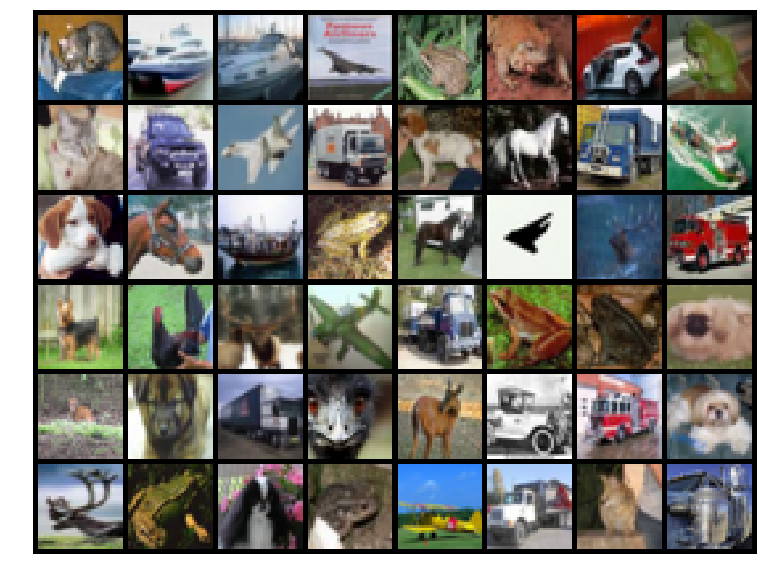

In [24]:
from torchvision.utils import make_grid

y = x.narrow(0, 0, 48).float()
collage = make_grid(y, normalize=True)
plt.figure(figsize=(20,10))
show(collage)

---

## Operations

### Point-wise operations

**Multiplication**

In [25]:
x = torch.ones(3,1)
y = torch.ones(3,1)*4
print(x)
print(y)

z = x*y
print(z)

tensor([[1.],
        [1.],
        [1.]])
tensor([[4.],
        [4.],
        [4.]])
tensor([[4.],
        [4.],
        [4.]])


**Squaring**

In [26]:
x = torch.ones(3,1)*2
print(x**2)

tensor([[4.],
        [4.],
        [4.]])


### Matrix-vector products

In [27]:
M = torch.tensor(
    [
        [1,2,3],
        [4,5,6],
        [7,8,0]
    ])
y = torch.tensor([1,2,3])
M.mv(y)

tensor([14, 32, 23])

### Matrix-matrix products

Matrix-matrix products are written via `@`. For a 2d tensor `M`, we can also equivalently write `M.mm(M)` to compute the matrix multiplication of `M` with itself, or `torch.mm(M,M)`.

In [28]:
print(M @ M)
print(M.mm(M)) # equivalent 
print(torch.mm(M,M)) # equivalent

tensor([[30, 36, 15],
        [66, 81, 42],
        [39, 54, 69]])
tensor([[30, 36, 15],
        [66, 81, 42],
        [39, 54, 69]])
tensor([[30, 36, 15],
        [66, 81, 42],
        [39, 54, 69]])


---
## Interface to standard linear operations

For instance, we can use `torch.gels` as a **least-squares** problem solver. Say you want to solve

$$ 
 \min_{\mathbf{X}}  \|\mathbf{A}\mathbf{X}-\mathbf{B}\|_2.
$$

for a given full-rank matrix $\mathbf{A}$ ($m \times n$) and a matrix $\mathbf{B}$ ($m \times k$). 

In the following **example**, $\mathbf{B}$ is of size $3 \times 1$ and $\mathbf{A}$ is of size $3 \times 3$. Both matrices will be filled with values from a standard Normal distribution.

In [30]:
B = torch.empty(3,1).normal_()   # 2d tensor of size 3x1 (i.e., a vector)
A = torch.empty(3,3).normal_()   # 2d tensor (matrix)

x, _ = torch.lstsq(B,A)

# some arbitrary vector just as a sanity check
z = torch.rand(3,1)

# Note: both x and z are 3x1 matrices (2d) tensors representing vectors
# Hence, we use mm() to compute matrix-matrix products.

Ax = A.mm(x)  
Az = A.mm(z) 

print('Norm (using x): {:.5f}'.format(torch.norm(Ax.view(3,) - B.view(3,)).item()))
print('Norm (using z): {:.5f}'.format(torch.norm(Az.view(3,) - B.view(3,)).item()))

Norm (using x): 0.00000
Norm (using z): 3.59030


### Solving linear least-squares regression

We are given 

$$(x_1,y_1), \ldots, (x_N,y_N)$$

with $(x_i,y_i) \in \mathbb{R} \times \mathbb{R}$ and want to fit the best **line** through this data, i.e.,

$$ f(x,a,b) = ax + b$$

This linear least squares **optimization problem** can be written as

$$ \arg\min_{a,b} \frac{1}{n} \sum_i (ax_i +b -y_i)^2$$

i.e., we try to minimize the sum of squared residuals $(ax_i +b -y_i)$.

Upon obtaining a solution, we can put in a (previously unseen) $x^*$ and predict the corresponding value $y^*$ via 

$$f(x^*,a,b)=\hat{y}$$

The toy data we use is taken from the [Isotonic Regression](https://scikit-learn.org/stable/auto_examples/plot_isotonic_regression.html#sphx-glr-auto-examples-plot-isotonic-regression-py) example from `sklearn`.

In [31]:
from sklearn.utils import check_random_state

N = 100
x = np.arange(N)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(N,)) + 50. * np.log1p(np.arange(N))

Note that `np.log1p(x)` returns $\log(1+x)$ and the toy data can obviously not modeled by a linear function - However, for our purposes this is *linear enough* as we will see.

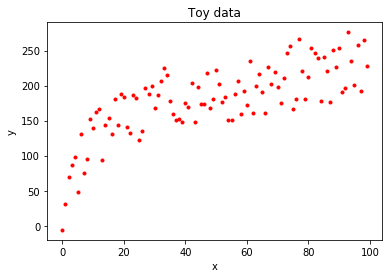

In [32]:
plt.plot(x,y,'r.')
plt.xlabel('x');
plt.ylabel('y');
plt.title('Toy data');

**Setting up the problem**    

First, we construct our $N \times 2$ data matrix $\mathbf{A}$ as follows:

$$\mathbf{A} = \left(
\begin{matrix}
x_1 & 1 \\
\vdots & \vdots \\
x_N & 1
\end{matrix}
\right)$$

We put our targets $y_i$ in a $N \times 1$ matrix (i.e., a colum vector)

$$\mathbf{B} = \left(
\begin{matrix}
y_1 \\
\vdots \\
y_N
\end{matrix}
\right)$$

**Goal**:

$$
\left(
\begin{matrix}
x_1 & 1 \\
\vdots & \vdots \\
x_N & 1
\end{matrix}
\right) 
\left(\begin{matrix}
a \\
b
\end{matrix}
\right)
\approx
\left(
\begin{matrix}
y_1 \\
\vdots \\
y_N
\end{matrix}
\right)
$$

Hence, we want to solve

$$ \min_{\mathbf{x}} \frac{1}{N} \| \mathbf{A}\mathbf{X} - \mathbf{B} \|_2^2$$

Note that this minimization problem is equivalent to 

$$ \min_{\mathbf{x}} \| \mathbf{A}\mathbf{X} - \mathbf{B} \|_2$$

as square-rooting the norm is a monotone transform (it does not matter which one we minimize). The latter, however, fits our setting of the `torch.gels()` function. Similarly, the missing $1/N$ term does not change the optimization result.

In [33]:
data_x = torch.empty(N, 2, dtype=torch.float)
data_y = torch.empty(N, 1, dtype=torch.float)

data_x[:,0] = torch.tensor([x])
data_x[:,1] = 1.
data_y[:,0] = torch.tensor([y])

In this example `data_x` acts as our matrix $\mathbf{A}$, and `data_y` acts as our matrix $\mathbf{B}$. $\mathbf{A}$ is of size $(m,n) = (N,2)$, $\mathbf{B}$ of size $(n,k) = (N,1)$. According to the documentation the returned solution has size $(\max(m,n), k)$, so we will get a matrix of size $(100,1)$ back.

In [34]:
alpha, _ = torch.lstsq(data_y, data_x)
print(alpha.size())

torch.Size([100, 1])


Again, according to the documentation, the first $n$ (in our case $n=2$) rows contain the solution, the remaining $100-2$ entries contain the residual sum of squares for the solution.

In [35]:
a, b = alpha[0,0].item(), alpha[1,0].item()
print(a,b)

1.3134796619415283 115.08245086669922


Just a quick comparison to the actual isotonic regression example in `sklearn`:

In [36]:
from sklearn.isotonic import IsotonicRegression
ir = IsotonicRegression()
y_ = ir.fit_transform(x, y)

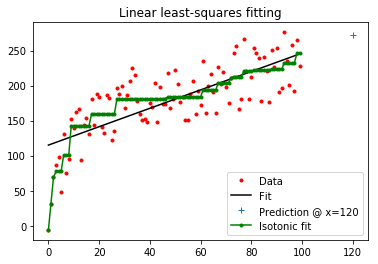

In [37]:
plt.figure()
plt.plot(x, y, 'r.', label='Data')
plt.plot(x, a*x + b, 'black', label='Fit')
plt.plot(120, a*120+b, '+', label='Prediction @ x=120')
plt.plot(x, y_, 'g.-', label='Isotonic fit')
plt.legend();
plt.title('Linear least-squares fitting');

In [38]:
from sklearn.metrics import r2_score

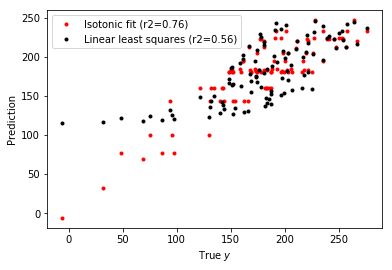

In [39]:
plt.plot(y,y_,'.',color='red', label='Isotonic fit (r2={:.2f})'.format(r2_score(y, y_)))
plt.plot(y,a*x+b,'.',color='black', label='Linear least squares (r2={:.2f})'.format(r2_score(y, a*x+b)))
plt.xlabel('True $y$');
plt.ylabel('Prediction');
plt.legend();